In [66]:
import random
import numpy as np
import time
from math import sqrt

In [67]:
class MemeticAlgorithm:
    def __init__(self, pop_size, n_item, item_weights,item_values,capacity,mutation_prob=0.8):
        #Initial values
        self.capacity = capacity
        self.n_item = n_item
        self.item_weights = item_weights
        self.item_values = item_values
        self.pop_size = pop_size
        self.population = [[0 for j in range(n_item)] for i in range(pop_size)]
        self.ith_generation = 0

        self.fitness_arr = [0 for i in range(self.pop_size)]

        self.mutation_prob = mutation_prob
        #Initial functions
        self.fitness_array_function()

    def sort_pop_by_fitness(self):
        n = self.pop_size
        swapped = False
        for i in range(n):
            for j in range(0, n-i-1):
                if self.fitness_arr[j] > self.fitness_arr[j + 1]:
                    swapped = True
                    self.fitness_arr[j], self.fitness_arr[j +
                                                          1] = self.fitness_arr[j + 1], self.fitness_arr[j]
                    self.population[j], self.population[j +
                                                        1] = self.population[j + 1], self.population[j]
            if not swapped:
                return
    def feasible_function(self,chromosome):
        total_weights = 0
        for i in range(self.n_item):
            if chromosome[i]==1:
                # try:
                total_weights += self.item_weights[i]
                # except:
                #     print(chromosome,i)
                #     raise f"hi{i}"
        return True if total_weights<=self.capacity else False 
    def fitness_function(self, chromosome):
        fitness_value = 0
        for i in range(self.n_item):
            # print(chromosome[i], chromosome[i+1])
            if chromosome[i]==1:
                fitness_value += self.item_values[i%self.n_item]
        return fitness_value
    
    def fitness_array_function(self):
        for ind in range(self.pop_size):
            current_fitness = self.fitness_function(self.population[ind])
            self.fitness_arr[ind] = current_fitness
        return self.fitness_arr
    
    def crossover(self, chromosome_A, chromosome_B):
        n = len(chromosome_A)
        # Choose two random crossover points
        point1 = random.randint(0, n-2)
        point2 = random.randint(point1+1, n-1)
        # Create two empty child arrays
        child1 = chromosome_A.copy()
        child2 = chromosome_B.copy()

        child1[point1:point2] = chromosome_B[point1:point2]
        child2[point1:point2] = chromosome_A[point1:point2]

        child1_fitness = self.fitness_function(child1)
        child2_fitness = self.fitness_function(child2)
        if child1_fitness > child2_fitness:
            return child1
        return child2
    

    def mutation(self, chromosome, mutation_prob, method='swap'):
        n = self.n_item
        if method == 'swap':
            if random.random() < mutation_prob:
                number_of_mutation = random.randint(0, int(0.4*self.n_item))
                for _ in range(number_of_mutation):
                    index1 = random.randint(0, self.n_item-1)
                    index2 = random.randint(0, self.n_item-1)

                    temp = chromosome
                    temp[index1], temp[index2] = temp[index2], temp[index1]
                    # if self.fitness_function(temp)>self.fitness_function(chromosome):
                    chromosome=temp
            return chromosome
        elif method == 'negation':
            new_chromosome = chromosome.copy()
            for i in range(self.n_item):
                if random.random()<0.2:
                    if new_chromosome[i] == 1:
                        new_chromosome[i] = 0
                    else:
                        new_chromosome[i] = 1
            return  new_chromosome
        
    def get_neighbor(self,chromosome,fitness,method='negation'):
        neighbor = chromosome.copy()
        if method=='swap':
            neighbor = chromosome.copy()
            req_1,req_2 = random.sample(range(self.n_item),2)
            neighbor[req_1], neighbor[req_2] = neighbor[req_2], neighbor[req_1]
        elif method=='negation':
            zeros = []
            ones = []
            for i,value in enumerate(chromosome):
                if chromosome[i]==0:
                    zeros.append((i,0))
                else:
                    ones.append((i,1))
            random_index = random.sample(zeros,1)[0][0]
            neighbor_add = chromosome.copy()
            neighbor_add[random_index] = 1
            neighbor_add_fitness = fitness + self.item_values[random_index]

            random_index = random.sample(ones,1)[0][0]
            neighbor_put = chromosome.copy()
            neighbor_put[random_index] = 0
            neighbor_put_fitness = fitness - self.item_values[random_index]

            is_neighbor_add_feasible = self.feasible_function(neighbor_add)
            is_neighbor_put_feasible = self.feasible_function(neighbor_put)

            if is_neighbor_add_feasible and is_neighbor_put_feasible:
                neighbor = neighbor_add if neighbor_add_fitness > neighbor_put_fitness else neighbor_put
            elif is_neighbor_add_feasible == True and is_neighbor_put_feasible == False:
                neighbor = neighbor_add
            elif  is_neighbor_add_feasible == False and is_neighbor_put_feasible == True:
                neighbor = neighbor_put
            else:
                neighbor = neighbor_add if neighbor_add_fitness > neighbor_put_fitness else neighbor_put
        return neighbor

    def local_search(self,chromosome,number_of_neighbors=10,random_p=0.2):
        neighbors_arr = [chromosome]
        neighbors_arr_fitnesses= [self.fitness_function(chromosome)]
        counter = 0
        limit_count = 0
        while counter < number_of_neighbors and limit_count<number_of_neighbors*5:
            neighbor = self.get_neighbor(chromosome,neighbors_arr_fitnesses[0])
            if neighbor not in neighbors_arr:
                neighbors_arr.append(neighbor)
                fitness = self.fitness_function(neighbor)
                neighbors_arr_fitnesses.append(fitness)
                counter += 1
            limit_count += 1

        best_fitness = neighbors_arr_fitnesses[0]
        fitness_id = 0
        for i in range(len(neighbors_arr)):
            if neighbors_arr_fitnesses[i] < best_fitness:
                fitness_id = i
                best_fitness = neighbors_arr_fitnesses[i]
        if random.random()<random_p:
            fitness_id = random.randint(0,len(neighbors_arr)-1)
        return neighbors_arr[fitness_id]

    def select(self, method='tournoment'):
        if method == 'tournoment':
            # random_population_index = np.array(random.sample(range(self.pop_size),self.pop_size))

            new_generation = []
            for i in range(0, self.pop_size):
                random_candidates = np.array(
                    random.sample(range(self.pop_size), 20))

                max_index1 = max(random_candidates,
                                 key=lambda j: self.fitness_arr[j])
                first_parent = (
                    max_index1, self.population[max_index1], self.fitness_arr[max_index1])

                random_candidates = np.array(
                    random.sample(range(self.pop_size), 5))
                max_index2 = max(random_candidates,
                                 key=lambda j: self.fitness_arr[j])
                second_parent = (
                    max_index2, self.population[max_index2], self.fitness_arr[max_index2])
                new_child = []
                while True:
                    new_child = self.crossover(first_parent[1], second_parent[1])
                    if self.feasible_function(new_child):
                        break
                while True:
                    new_child = self.mutation(new_child, self.mutation_prob,method='negation')
                    # print(new_child)
                    if self.feasible_function(new_child):
                        break
                new_child = self.local_search(new_child,number_of_neighbors=20)
                new_generation.append(new_child)

            # new_generation.sort(key=lambda item: self.fitness_function(item))
            # self.sort_pop_by_fitness()
            # self.population[0:len(new_generation)-1]=new_generation

            new_gen_len = len(new_generation)
            # self.population[self.pop_size - 1: self.pop_size - 1-len(new_generation)-1] = new_generation

            for index in range(new_gen_len-1,-1,-1):
                if self.fitness_function(new_generation[index]) > self.fitness_arr[self.pop_size-1-new_gen_len-1+index]:
                    self.population[index] = new_generation[index]
            # self.sort_pop_by_fitness()
            # self.population=np.concatenate(( new_generation, self.population[self.pop_size-len(new_generation)+1:]), axis=0)
            # self.population = self.population[0:self.pop_size-len(new_generation)] + new_generation
            self.fitness_arr = self.fitness_array_function()

        elif method == 'ranked':
            new_generation = []
            self.sort_pop_by_fitness()
            self.fitness_arr = self.fitness_array_function()
            for i in range(self.pop_size-1):
                first_parent = self.population[i]
                second_parent = self.population[i+1]

                new_child = self.crossover(first_parent, second_parent)
                mutation_prob = random.random()
                new_child = self.mutation(new_child, mutation_prob)
                new_generation.append(new_child)

                self.population[0:len(new_generation)-1] = new_generation

            self.fitness_arr = self.fitness_array_function()
        self.ith_generation+=1

    



In [68]:
def max_knapsack(pop_size, n_item, weights,values,stop_point,max_gen=2000):
    ith_gen_arr = []
    max_value = []

    model = MemeticAlgorithm(pop_size=pop_size,n_item=n_item,item_weights=weights,item_values=values,capacity=capacity)
    print(model.population)
    # ith_gen_arr.append(model.ith_generation)
    # max_value.append(max(model.fitness_arr))
    best_ans = model.population[0]
    best_fitness = model.fitness_arr[0]
    while (best_fitness < stop_point and model.ith_generation < max_gen):
        model.select()
        ith_gen_arr.append(model.ith_generation)
        max_value.append(max(model.fitness_arr))
        if max_value[-1]>best_fitness:
            best_fitness = max_value[-1]
            best_ans = model.population[model.fitness_arr.index(max(model.fitness_arr))]
        print(f"{model.ith_generation}th : {max(model.fitness_arr)} and best fitness unitll now is {best_fitness}")

    print(
        f"\n{n_item}-item knapsack problem solved in generation {ith_gen_arr[-1]}th with population of{pop_size}")
    print(f"best fitness(maximum value) is:{max(max_value)} with { best_ans }")  
    print('----------------------------------------')
    return (ith_gen_arr ,max_value)

In [69]:
n_item = 20
weights = [92, 4, 43, 83, 84, 68, 92, 
82, 6, 44, 32, 18, 56, 83, 25, 96, 70, 48, 14, 58]
values = [44, 46, 90, 
72, 91, 40, 75, 35, 8, 54, 78, 40, 77, 15, 61, 17, 75, 29, 75, 63]
capacity = 878

In [70]:
x , y = max_knapsack(pop_size=100,n_item=n_item,weights=weights,values=values,stop_point=1000,max_gen=500)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 

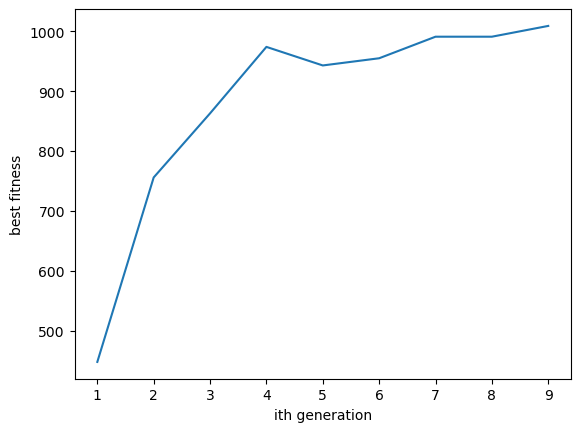

In [71]:
import matplotlib.pyplot as plt

plt.plot(x, y)
plt.xlabel("ith generation")
plt.ylabel("best fitness")

plt.show()


In [72]:
n_item = 50

weights = [80, 82, 85, 70, 72, 70, 
66, 50, 55, 25, 50, 55, 40, 48, 50, 32, 22, 60, 30, 32, 40, 38, 35, 
32, 25, 28, 30, 22, 50, 30, 45, 30, 60, 50, 20, 65, 20, 25, 30, 10, 
20, 25, 15, 10, 10, 10, 4, 4, 2, 1]
values = [220, 208, 198, 192, 180, 180, 165, 162, 160, 158, 155, 
130, 125, 122, 120, 118, 115, 110, 105, 101, 100, 100, 98, 96, 
95, 90, 88, 82, 80, 77, 75, 73, 72, 70, 69, 66, 65, 63, 60, 58, 56, 
50, 30, 20, 15, 10, 8, 5, 3, 1]
capacity = 1000
print(weights)
print(values)

[80, 82, 85, 70, 72, 70, 66, 50, 55, 25, 50, 55, 40, 48, 50, 32, 22, 60, 30, 32, 40, 38, 35, 32, 25, 28, 30, 22, 50, 30, 45, 30, 60, 50, 20, 65, 20, 25, 30, 10, 20, 25, 15, 10, 10, 10, 4, 4, 2, 1]
[220, 208, 198, 192, 180, 180, 165, 162, 160, 158, 155, 130, 125, 122, 120, 118, 115, 110, 105, 101, 100, 100, 98, 96, 95, 90, 88, 82, 80, 77, 75, 73, 72, 70, 69, 66, 65, 63, 60, 58, 56, 50, 30, 20, 15, 10, 8, 5, 3, 1]


In [73]:
x , y = max_knapsack(pop_size=100,n_item=n_item,weights=weights,values=values,stop_point=3000)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

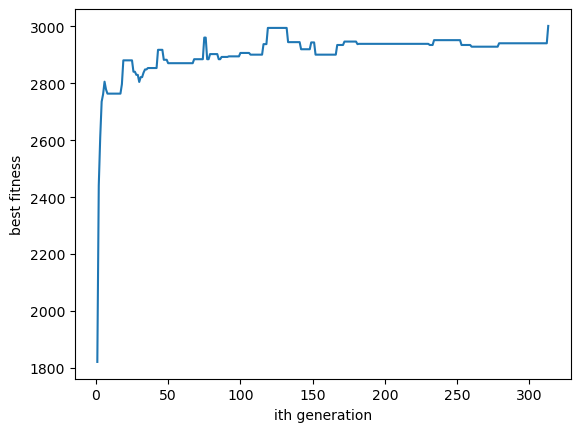

In [74]:
import matplotlib.pyplot as plt

plt.plot(x, y)
plt.xlabel("ith generation")
plt.ylabel("best fitness")

plt.show()
